In [122]:
import torch
from torch import nn

torch.__version__

'2.0.0a0'

In [123]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [124]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
images_path = data_path / "pizza_steak_sushi"

if images_path.is_dir():
    print(f"{images_path} directory exists.")
else:
    print(f"Did not find {images_path} directory, creating one...")
    images_path.mkdir(parents=True, exist_ok=True)
    
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(images_path)

data/pizza_steak_sushi directory exists.


In [125]:
import os
def walk_through_dir(dir_path: str):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(images_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [126]:
train_dir = images_path / "train"
test_dir = images_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image pat: data/pizza_steak_sushi/test/pizza/195160.jpg
Image class: pizza
CHW: RGB, 384, 512


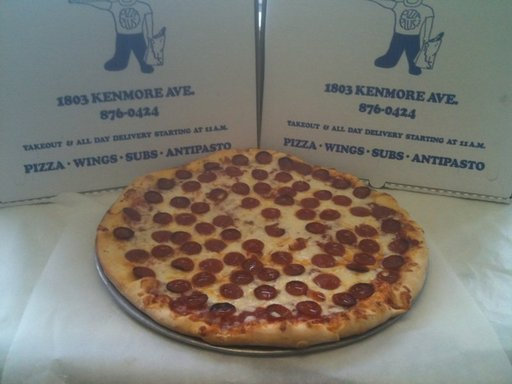

In [127]:
import random
from PIL import Image # python image library

random.seed(42)

images_path_list = list(images_path.glob("*/*/*.jpg"))

random_image_path = random.choice(images_path_list) # get a random image file from all the imgs

image_class = random_image_path.parent.stem # parent dir name

img = Image.open(random_image_path)

print(f"Random image pat: {random_image_path}")
print(f"Image class: {image_class}")
print(f"CHW: {img.mode}, {img.height}, {img.width}")
img

In [128]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms # transforms is for formatting images
# data augmentation: the practice of altering data to make it harder for a model to learn

In [129]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5), # 50% probability of flip
    transforms.ToTensor() # pixel values to 0-255 and between 0.0 and 1.0
])

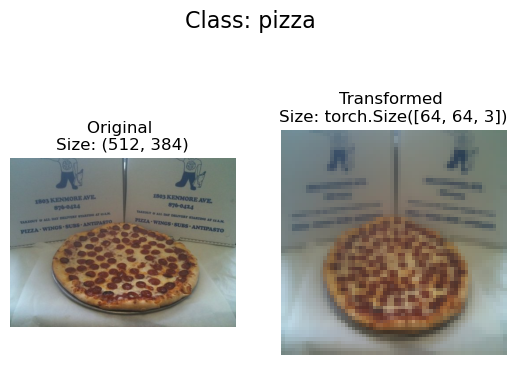

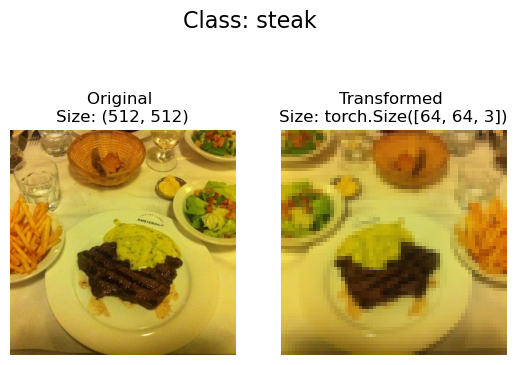

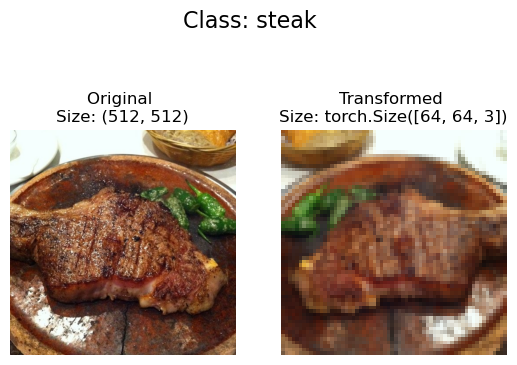

In [130]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(images_path_list,
                       transform=data_transform,
                       n=3)

In [131]:
# making our own custom Dataset class for custom data
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [132]:
from torch.utils.data import Dataset
class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir: str, transform=None) -> None:
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = self.find_classes(targ_dir)
      
    @staticmethod
    def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # optional for subclassses
    def __len__(self) -> int:
        return len(self.paths)
    
    # required for subclasses
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [133]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [134]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                     transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                    transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f3c8feee210>,
 <__main__.ImageFolderCustom at 0x7f3bfae2e1d0>)

In [135]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                         classes: List[str]=None,
                         n: int=10,
                         display_shape: bool=True,
                         seed: int=None):
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 to remove errors")
    if seed: random.seed(seed)
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(16,8))
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        targ_image_adjust = targ_image.permute(1, 2, 0)
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape: title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)
    

In [136]:
class_names = train_data_custom.classes

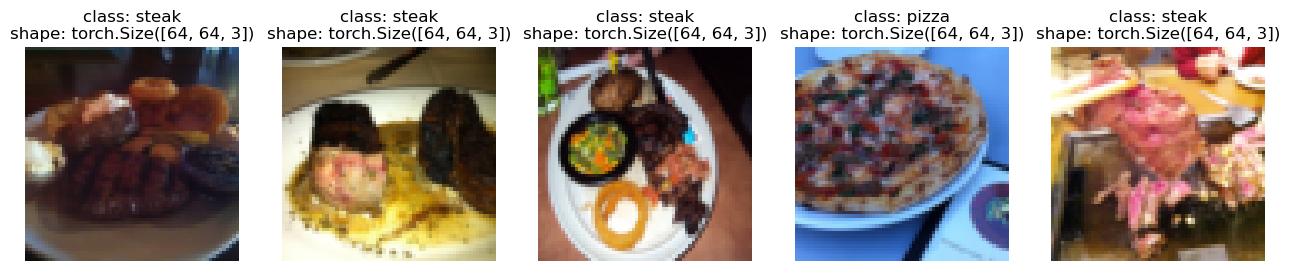

In [137]:
display_random_images(train_data_custom,
                     n=5,
                     classes=class_names,
                     seed=None)

In [138]:
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                    batch_size=1,
                                    num_workers=0, # subprocesses
                                    shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                   batch_size=1,
                                   num_workers=0,
                                   shuffle=False)

In [139]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # intensity of transforms
    transforms.ToTensor() # last to get between 0 and 1
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

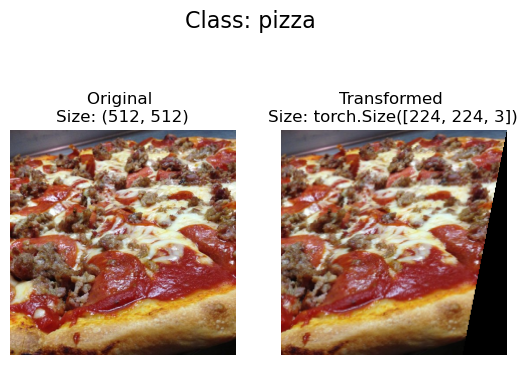

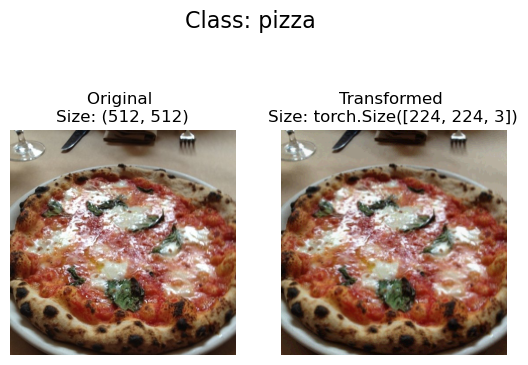

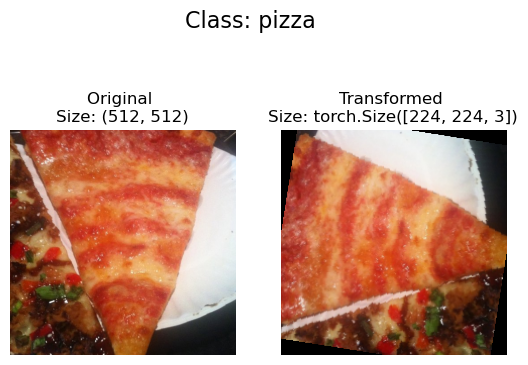

In [140]:
# testing our data augmentation out
image_path_list = list(images_path.glob("*/*/*.jpg"))

plot_transformed_images(image_paths=image_path_list,
                       transform=train_transforms,
                       n=3,
                       seed=None)

In [141]:
# classification here

In [142]:
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [143]:
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS= os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

train_dataloader_simple = DataLoader(train_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   num_workers=NUM_WORKERS)

Creating DataLoader's with batch size 32 and 16 workers.


In [144]:
# model
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,
                     kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        #x = self.conv_block_1(x)
        #x = self.conv_block_2(x)
        #x = self.classifier(x)
        #return x
        
        # <- leverage the benefits of operator fusion
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) 

In [145]:
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        # normalize y_pred on probability distribution then get argmax
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [146]:
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [147]:
def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module=nn.CrossEntropyLoss(), epochs: int=5):
    results = {"train_loss": [], "train_acc": [],
               "test_loss": [], "test_acc": []}
    
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn)
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

In [148]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(train_data_custom.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

In [149]:
img_batch, label_batch = next(iter(train_dataloader_simple))

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]])

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]])

Output prediction label:
tensor([1])

Actual label:
2


In [150]:
from timeit import default_timer as timer
start_time = timer()
NUM_EPOCHS = 5

model_0_results = train(model=model_0, train_dataloader=train_dataloader_simple,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total running time: {end_time-start_time:.3f} seconds")

Epoch: 1 | train_loss: 1.0976 | train_acc: 0.2617 | test_loss: 1.1037 | test_acc: 0.2083
Epoch: 2 | train_loss: 1.0972 | train_acc: 0.3828 | test_loss: 1.1037 | test_acc: 0.2083
Epoch: 3 | train_loss: 1.0977 | train_acc: 0.2617 | test_loss: 1.1037 | test_acc: 0.2083
Epoch: 4 | train_loss: 1.0973 | train_acc: 0.3828 | test_loss: 1.1037 | test_acc: 0.2083
Epoch: 5 | train_loss: 1.0972 | train_acc: 0.3828 | test_loss: 1.1037 | test_acc: 0.2083
Total running time: 5.859 seconds


In [151]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [152]:
def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    epochs = range(len(results["train_loss"]))
    
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

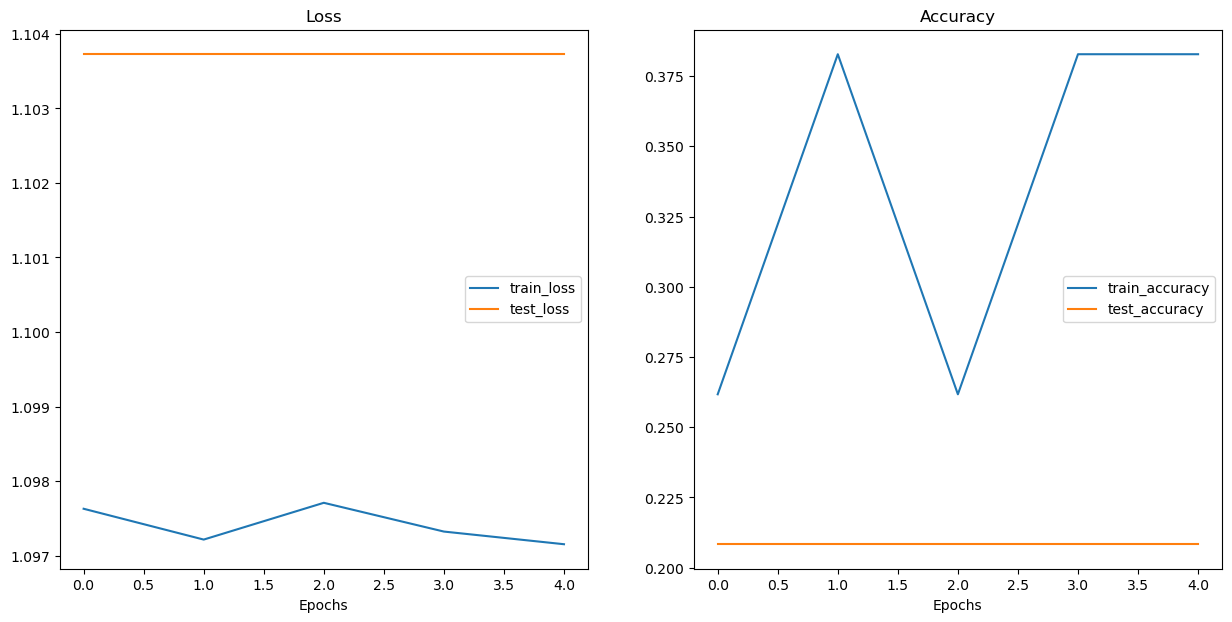

In [154]:
plot_loss_curves(model_0_results)

In [155]:
# problem with overfitting and underfitting 